# Support Vector Machine

## 1. Download the CIFAR10 datasets, and load it

You have two ways to download the CIFAR10 datasets:
- cd the path to './CIFAR10/datasets/', and run the 'get_datasets.sh'. Then it will automatically download the datasets and decompress it.
- Enter the CIFAR10 website: http://www.cs.toronto.edu/~kriz/cifar.html and manually download the python version. Then put the datasets in local folder './CIFAR10/datasets/'.

The CIFAR10 datasets named 'cifar-10-batches-py/'

### Setup code

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from CIFAR10.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Load the CIFAR10 dataset

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'CIFAR10/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Show some CIFAR10 images

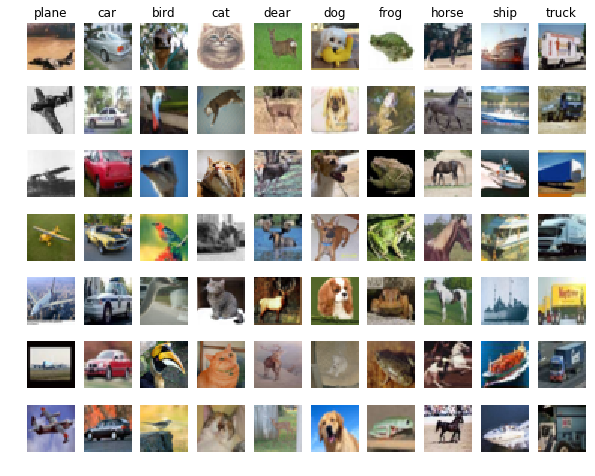

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Subsample the data for more efficient code execution

In [4]:
# Split the data into train, val, and test sets
num_train = 49000
num_val = 1000
num_test = 1000

# Validation set
mask = range(num_train, num_train + num_val)
X_val = X_train[mask]
y_val = y_train[mask]

# Train set
mask = range(num_train)
X_train = X_train[mask]
y_train = y_train[mask]

# Test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## 2. Preprocessing

### Reshape the images data into rows

In [5]:
# Preprocessing: reshape the images data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


### Subtract the mean images

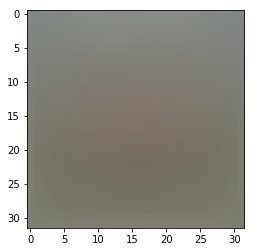

In [6]:
# Processing: subtract the mean images
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()

In [7]:
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

### Append the bias dimension of ones

In [8]:
# append the bias dimension of ones (i.e. bias trick)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (49000, 3073)
Validation data shape:  (1000, 3073)
Test data shape:  (1000, 3073)


## 3. Define a linear SVM classifier

In [9]:
class LinearSVM(object):
    """ A subclass that uses the Multiclass SVM loss function """
    def __init__(self):
        self.W = None
    
    def loss_naive(self, X, y, reg):
        """
        Structured SVM loss function, naive implementation (with loops).
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i]
        - reg: float, regularization strength
        Return:
        - loss: the loss value between predict value and ground truth
        - dW: gradient of W
        """
        
        # Initialize loss and dW
        loss = 0.0
        dW = np.zeros(self.W.shape)
        
        # Compute the loss and dW
        num_train = X.shape[0]
        num_classes = self.W.shape[1] 
        for i in range(num_train):
            scores = np.dot(X[i], self.W)
            for j in range(num_classes):
                if j == y[i]:
                    margin = 0
                else:
                    margin = scores[j] - scores[y[i]] + 1    # delta = 1
                    if margin > 0:
                        loss += margin
                        dW[:,j] += X[i].T
                        dW[:,y[i]] += -X[i].T
        # Divided by num_train
        loss /= num_train
        dW /= num_train
        
        # Add regularization
        loss += 0.5 * reg * np.sum(self.W * self.W)
        dW += reg * self.W
        
        return loss, dW
    def loss_vectorized(self, X, y, reg):
        """
        Structured SVM loss function, naive implementation (with loops).
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i]
        - reg: (float) regularization strength
        Outputs:
        - loss: the loss value between predict value and ground truth
        - dW: gradient of W
        """
        
         # Initialize loss and dW
        loss = 0.0
        dW = np.zeros(self.W.shape)
        
        # Compute the loss
        num_train = X.shape[0]
        scores = np.dot(X, self.W)
        correct_score = scores[range(num_train), list(y)].reshape(-1, 1)    # delta = -1
        margin = np.maximum(0, scores - correct_score + 1)
        margin[range(num_train), list(y)] = 0
        loss = np.sum(margin) / num_train + 0.5 * reg * np.sum(self.W * self.W)
        
        # Compute the dW
        num_classes = self.W.shape[1]
        mask = np.zeros((num_train, num_classes))
        mask[margin > 0] = 1
        mask[range(num_train), list(y)] = 0
        mask[range(num_train), list(y)] = -np.sum(mask, axis=1)
        dW = np.dot(X.T, mask)
        dW = dW / num_train + reg * self.W
        
        return loss, dW
    
    def train(self, X, y, learning_rate = 1e-3, reg = 1e-5, num_iters = 100, 
             batch_size = 200, print_flag = False):
        """
        Train linear SVM classifier using SGD
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
          consisting of num_train samples each of dimension D
        - y: A numpy array of shape (num_train,) contain the training labels,
          where y[i] is the label of X[i], y[i] = c, 0 <= c <= C
        - learning rate: (float) learning rate for optimization
        - reg: (float) regularization strength
        - num_iters: (integer) numbers of steps to take when optimization
        - batch_size: (integer) number of training examples to use at each step
        - print_flag: (boolean) If true, print the progress during optimization
        Outputs:
        - loss_history: A list containing the loss at each training iteration
        """
        
        loss_history = []
        num_train = X.shape[0]
        dim = X.shape[1]
        num_classes = np.max(y) + 1
        
        # Initialize W
        if self.W == None:
            self.W = 0.001 * np.random.randn(dim, num_classes)
        
        # iteration and optimization
        for t in range(num_iters):
            idx_batch = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[idx_batch]
            y_batch = y[idx_batch]
            loss, dW = self.loss_vectorized(X_batch, y_batch, reg)
            loss_history.append(loss)
            self.W += -learning_rate * dW
            
            if print_flag and t%100 == 0:
                print('iteration %d / %d: loss %f' % (t, num_iters, loss))
        
        return loss_history
    
    def predict(self, X):
        """
        Use the trained weights of linear SVM to predict data labels
        Inputs:
        - X: A numpy array of shape (num_train, D) contain the training data
        Outputs:
        - y_pred: A numpy array, predicted labels for the data in X
        """
        
        y_pred = np.zeros(X.shape[0])
        scores = np.dot(X, self.W)
        y_pred = np.argmax(scores, axis=1)
        
        return y_pred        

## 4. Gradient Check

### Define loss function

In [10]:
def loss_naive1(X, y, W, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs:
    - X: A numpy array of shape (num_train, D) contain the training data
    consisting of num_train samples each of dimension D
    - y: A numpy array of shape (num_train,) contain the training labels,
    where y[i] is the label of X[i]
    - W: A numpy array of shape (D, C) contain the weights
    - reg: float, regularization strength
    Return:
    - loss: the loss value between predict value and ground truth
    - dW: gradient of W
    """
        
    # Initialize loss and dW
    loss = 0.0
    dW = np.zeros(W.shape)
        
    # Compute the loss and dW
    num_train = X.shape[0]
    num_classes = W.shape[1] 
    for i in range(num_train):
        scores = np.dot(X[i], W)
        for j in range(num_classes):
            if j == y[i]:
                margin = 0
            else:
                margin = scores[j] - scores[y[i]] + 1    # delta = 1
                if margin > 0:
                    loss += margin
                    dW[:,j] += X[i].T
                    dW[:,y[i]] += -X[i].T
    # Divided by num_train
    loss /= num_train
    dW /= num_train
        
    # Add regularization
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg * W
    
    return loss, dW

def loss_vectorized1(X, y, W, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs:
    - X: A numpy array of shape (num_train, D) contain the training data
    consisting of num_train samples each of dimension D
    - y: A numpy array of shape (num_train,) contain the training labels,
    where y[i] is the label of X[i]
    - W: A numpy array of shape (D, C) contain the weights
    - reg: (float) regularization strength
    Outputs:
    - loss: the loss value between predict value and ground truth
    - dW: gradient of W
    """
        
    # Initialize loss and dW
    loss = 0.0
    dW = np.zeros(W.shape)
        
    # Compute the loss
    num_train = X.shape[0]
    scores = np.dot(X, W)
    correct_score = scores[range(num_train), list(y)].reshape(-1, 1)    # delta = -1
    margin = np.maximum(0, scores - correct_score + 1)
    margin[range(num_train), list(y)] = 0
    loss = np.sum(margin) / num_train + 0.5 * reg * np.sum(W * W)
        
    # Compute the dW
    num_classes = W.shape[1]
    mask = np.zeros((num_train, num_classes))
    mask[margin > 0] = 1
    mask[range(num_train), list(y)] = 0
    mask[range(num_train), list(y)] = -np.sum(mask, axis=1)
    dW = np.dot(X.T, mask)
    dW = dW / num_train + reg * W
        
    return loss, dW

### Gradient check

In [11]:
from gradient_check import grad_check_sparse
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

# Without regularization
loss, dW = loss_naive1(X_val, y_val, W, 0)
f = lambda W: loss_naive1(X_val, y_val, W, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, dW)

# With regularization
loss, dW = loss_naive1(X_val, y_val, W, 5e1)
f = lambda W: loss_naive1(X_val, y_val, W, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, dW)

numerical: -8.059958 analytic: -8.059958, relative error: 6.130237e-11
numerical: -7.522645 analytic: -7.522645, relative error: 3.601909e-11
numerical: 14.561062 analytic: 14.561062, relative error: 1.571510e-11
numerical: -0.636243 analytic: -0.636243, relative error: 7.796694e-10
numerical: -11.414171 analytic: -11.414171, relative error: 1.604323e-11
numerical: 12.628817 analytic: 12.628817, relative error: 1.141476e-11
numerical: -9.642228 analytic: -9.642228, relative error: 2.188900e-11
numerical: 9.577850 analytic: 9.577850, relative error: 6.228243e-11
numerical: -5.397272 analytic: -5.397272, relative error: 4.498183e-11
numerical: 12.226704 analytic: 12.226704, relative error: 5.457544e-11
numerical: 14.054682 analytic: 14.054682, relative error: 2.879899e-12
numerical: 0.444995 analytic: 0.444995, relative error: 4.021959e-10
numerical: 0.838312 analytic: 0.838312, relative error: 6.444258e-10
numerical: -1.160105 analytic: -1.160105, relative error: 5.096445e-10
numerical:

### loss_naive vs. loss_vectorized

In [12]:
t_st = time.time()
loss_naive, dW_naive = loss_naive1(X_val, y_val, W, 0.00005)
t_ed = time.time()
print('Naive loss: %e computed in %f seconds.' % (loss_naive, t_ed - t_st))
t_st = time.time()
loss_vectorized, dW_vectorized = loss_vectorized1(X_val, y_val, W, 0.00005)
t_ed = time.time()
print('Vectorized loss: %e computed in %f seconds.' % (loss_vectorized, t_ed - t_st))

diff_loss = loss_naive - loss_vectorized
diff_dW = np.linalg.norm(dW_naive - dW_vectorized, ord='fro')
print('Difference of loss: %f' % diff_loss)
print('Difference of dW: %f' % diff_dW)

Naive loss: 9.382264e+00 computed in 0.242533 seconds.
Vectorized loss: 9.382264e+00 computed in 0.022621 seconds.
Difference of loss: 0.000000
Difference of dW: 0.000000


## 4. Stochastic Gradient Descent

In [13]:
svm = LinearSVM()
loss_history = svm.train(X_train, y_train, learning_rate = 1e-7, reg = 2.5e4, num_iters = 2000, 
             batch_size = 200, print_flag = True)


iteration 0 / 2000: loss 403.810828
iteration 100 / 2000: loss 239.004354
iteration 200 / 2000: loss 145.934813
iteration 300 / 2000: loss 90.564682
iteration 400 / 2000: loss 56.126912
iteration 500 / 2000: loss 36.482452
iteration 600 / 2000: loss 23.327738
iteration 700 / 2000: loss 15.934542
iteration 800 / 2000: loss 11.508418
iteration 900 / 2000: loss 8.614351
iteration 1000 / 2000: loss 7.845596
iteration 1100 / 2000: loss 6.068847
iteration 1200 / 2000: loss 6.017030
iteration 1300 / 2000: loss 5.407498
iteration 1400 / 2000: loss 5.282425
iteration 1500 / 2000: loss 5.760450
iteration 1600 / 2000: loss 4.764250
iteration 1700 / 2000: loss 5.395108
iteration 1800 / 2000: loss 5.025213
iteration 1900 / 2000: loss 4.858321


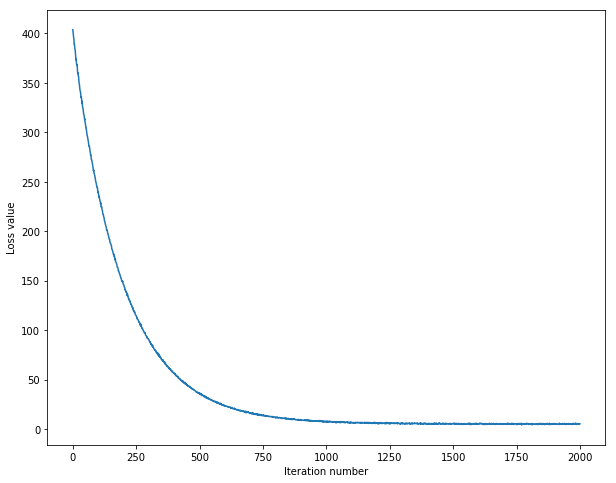

In [14]:
# Plot the loss_history
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Use svm to predict
# Training set
y_pred = svm.predict(X_train)
num_correct = np.sum(y_pred == y_train)
accuracy = np.mean(y_pred == y_train)
print('Training correct %d/%d: The accuracy is %f' % (num_correct, X_train.shape[0], accuracy))

# Test set
y_pred = svm.predict(X_test)
num_correct = np.sum(y_pred == y_test)
accuracy = np.mean(y_pred == y_test)
print('Test correct %d/%d: The accuracy is %f' % (num_correct, X_test.shape[0], accuracy))

Training correct 18789/49000: The accuracy is 0.383449
Test correct 375/1000: The accuracy is 0.375000


## 5. Validation and Test

### Cross-validation

In [16]:
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = [8000.0, 9000.0, 10000.0, 11000.0, 18000.0, 19000.0, 20000.0, 21000.0]

results = {}
best_lr = None
best_reg = None
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_history = svm.train(X_train, y_train, learning_rate = lr, reg = reg, num_iters = 2000)
        y_train_pred = svm.predict(X_train)
        accuracy_train = np.mean(y_train_pred == y_train)
        y_val_pred = svm.predict(X_val)
        accuracy_val = np.mean(y_val_pred == y_val)
        if accuracy_val > best_val:
            best_lr = lr
            best_reg = reg
            best_val = accuracy_val
            best_svm = svm
        results[(lr, reg)] = accuracy_train, accuracy_val
        print('lr: %e reg: %e train accuracy: %f val accuracy: %f' %
              (lr, reg, results[(lr, reg)][0], results[(lr, reg)][1]))
print('Best validation accuracy during cross-validation:\nlr = %e, reg = %e, best_val = %f' %
      (best_lr, best_reg, best_val))     

lr: 1.400000e-07 reg: 8.000000e+03 train accuracy: 0.388633 val accuracy: 0.412000
lr: 1.400000e-07 reg: 9.000000e+03 train accuracy: 0.394918 val accuracy: 0.396000
lr: 1.400000e-07 reg: 1.000000e+04 train accuracy: 0.392388 val accuracy: 0.396000
lr: 1.400000e-07 reg: 1.100000e+04 train accuracy: 0.388265 val accuracy: 0.379000
lr: 1.400000e-07 reg: 1.800000e+04 train accuracy: 0.387408 val accuracy: 0.386000
lr: 1.400000e-07 reg: 1.900000e+04 train accuracy: 0.381673 val accuracy: 0.372000
lr: 1.400000e-07 reg: 2.000000e+04 train accuracy: 0.377531 val accuracy: 0.394000
lr: 1.400000e-07 reg: 2.100000e+04 train accuracy: 0.372735 val accuracy: 0.370000
lr: 1.500000e-07 reg: 8.000000e+03 train accuracy: 0.393837 val accuracy: 0.400000
lr: 1.500000e-07 reg: 9.000000e+03 train accuracy: 0.393735 val accuracy: 0.382000
lr: 1.500000e-07 reg: 1.000000e+04 train accuracy: 0.395735 val accuracy: 0.381000
lr: 1.500000e-07 reg: 1.100000e+04 train accuracy: 0.396469 val accuracy: 0.398000
lr: 

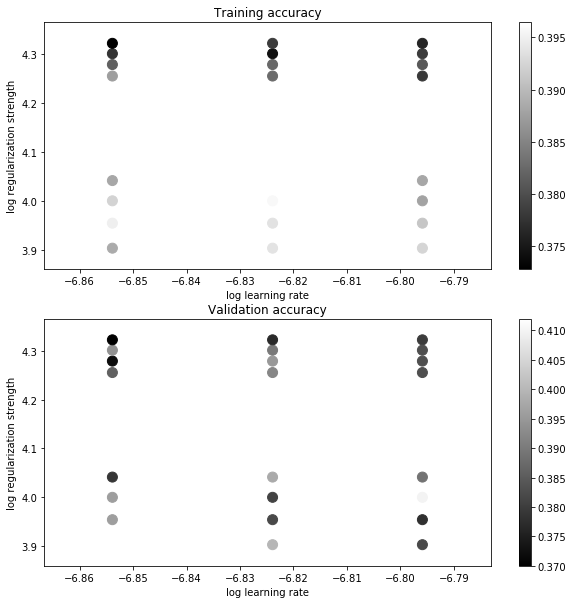

In [17]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Plot training accuracy
plt.figure(figsize=(10,10))
make_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, make_size, c = colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Training accuracy')

# Plot validation accuracy
colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, make_size, c = colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Validation accuracy')
plt.show()

### Test

In [18]:
# Use the best svm to test
y_test_pred = best_svm.predict(X_test)
num_correct = np.sum(y_test_pred == y_test)
accuracy = np.mean(y_test_pred == y_test)
print('Test correct %d/%d: The accuracy is %f' % (num_correct, X_test.shape[0], accuracy))

Test correct 369/1000: The accuracy is 0.369000


### Visualize the weights for each class

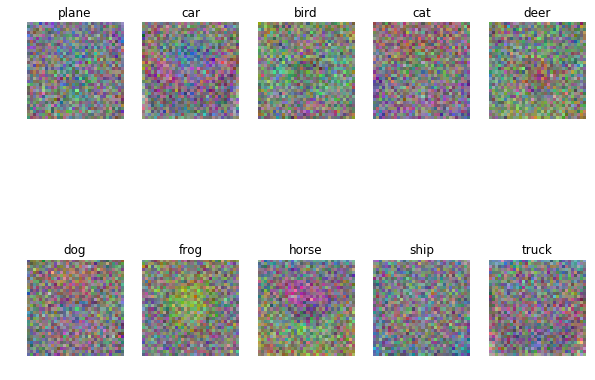

In [19]:
W = best_svm.W[:-1, :]    # delete the bias
W = W.reshape(32, 32, 3, 10)
W_min, W_max = np.min(W), np.max(W)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i+1)
    imgW = 255.0 * ((W[:, :, :, i].squeeze() - W_min) / (W_max - W_min))
    plt.imshow(imgW.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()